# Malware Family Classification: Word2Vec + CNN

> Author: Tien Ly  
> CS 271: Topics in Machine Learning - Spring 2025 at San Jose State University

This notebook implements a CNN-based classifier to identify malware families from API call sequences. API calls are first converted into Word2Vec embeddings, which are then fed into a multi-filter CNN to learn distinguishing patterns across malware families. This notebook is the second part of a multi-notebook project on malware classification using traditional and deep learning approaches.

Note: The first notebook in the series is `malware-ml.ipynb`.

## Section 1: Data Loading

In [1]:
# %pip install numpy pandas matplotlib seaborn scikit-learn xgboost gensim transformers torch ipykernel ipywidgets

In [2]:
# Imports
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [3]:
def set_seed(seed_value=42):
    """ Set random seeds for reproducibility """

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

set_seed(42)

In [4]:
base_path = 'data_family/AllFiles_CleanLogAPI'
malware_families = os.listdir(base_path)
malware_families.sort()

print(f'Malware families: {malware_families}')

Malware families: ['adload', 'bancos', 'onlinegames', 'vbinject', 'vundo', 'winwebsec', 'zwangi']


In [5]:
# Read the dataset prepared in the previous notebook (malware1.ipynb)
malware = pd.read_pickle('malware.pkl')
display(malware)

,filename,family,api_calls,family_encoded
0,VirusShare_000e2f2b46fe9a883f550a2c493bc86e_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0
1,VirusShare_00e7a6c7cedd158560fdf691e2bd86c8_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0
2,VirusShare_0191bf41bdbd64cc2a789824038b136f_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0
3,VirusShare_019c795a6bedb2aae2392590dc35eab1_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0
4,VirusShare_0239ea751e7de5ea1cb0c463e924c469_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0
...,...,...,...,...
487,VirusShare_ee8abd8831806a06a85e8821db773277_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...,6
488,VirusShare_f2b606c3319af4d2e99d308520f2b956_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...,6
489,VirusShare_f30c6a1331242ca842337334d9d251bc_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...,6
490,VirusShare_f316af76d837f5444d3ff1bd03b76409_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...,6


## Section 2: Word2Vec Data Preparation

### 2.1 Word2Vec

In [6]:
# Split API calls into tokens for Word2Vec
corpus = [file.split() for file in malware['api_calls']]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=1)
print(w2v_model)

Word2Vec<vocab=79, vector_size=100, alpha=0.025>


### 2.2 PyTorch Data Preparation

In [7]:
def tokens_to_ids(api_calls, key_to_index):
    """
    Converts API call tokens to their corresponding indices in the Word2Vec model

    Args:
        api_calls (str): Space-separated API call sequence
        key_to_index (dict): Dictionary mapping tokens to their indices in the Word2Vec model
    
    Returns:
        list: List of indices corresponding to the API call tokens
    """
    return [key_to_index[call] for call in api_calls.split() if call in key_to_index]

w2v_token_ids = malware['api_calls'].apply(
    lambda api_calls: tokens_to_ids(api_calls, w2v_model.wv.key_to_index))

In [8]:
# Convert to PyTorch tensors
w2v_token_id_tensors = [torch.tensor(seq) for seq in w2v_token_ids]
X_word2vec_tensor = pad_sequence(w2v_token_id_tensors, batch_first=True)

w2v_embedding_tensors = torch.tensor(w2v_model.wv.vectors)

y_tensor = torch.tensor(malware['family_encoded'])

# Split the data into training, validation, and test sets (80% training, 10% validation, 10% test)
X_train_word2vec_tensor, X_temp_word2vec_tensor, y_train_word2vec_tensor, y_temp_word2vec_tensor = \
    train_test_split(X_word2vec_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y_tensor)

X_val_word2vec_tensor, X_test_word2vec_tensor, y_val_word2vec_tensor, y_test_word2vec_tensor = \
    train_test_split(X_temp_word2vec_tensor, y_temp_word2vec_tensor, test_size=0.5, random_state=42, stratify=y_temp_word2vec_tensor)

In [9]:
# Create TensorDataset objects
w2v_train_dataset = TensorDataset(X_train_word2vec_tensor, y_train_word2vec_tensor)
w2v_val_dataset = TensorDataset(X_val_word2vec_tensor, y_val_word2vec_tensor)
w2v_test_dataset = TensorDataset(X_test_word2vec_tensor, y_test_word2vec_tensor)

In [10]:
BATCH_SIZE = 50

# Create DataLoader objects for batch processing
w2v_train_loader = DataLoader(w2v_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
w2v_val_loader = DataLoader(w2v_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
w2v_test_loader = DataLoader(w2v_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Section 3: Word2Vec-CNN Model

In [11]:
# Set computation device
if torch.cuda.is_available():       
    device = torch.device('cuda')
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
Device name: NVIDIA RTX 4000 Ada Generation


### 3.1 Model Architecture

In [12]:
class W2V_CNN(nn.Module):
    def __init__(self, embedding_matrix, num_classes, freeze_embedding=False, num_filters=100, filter_sizes=[3, 4, 5], dropout_rate=0.5):
        """
        W2V_CNN model for API call sequence classification
        
        Args:
            embedding_matrix (torch.Tensor): Pre-trained Word2Vec embeddings
            freeze_embedding (bool): Whether to freeze the embedding layer
            num_filters (int): Number of filters per filter size
            filter_sizes (list[int]): Different sizes of filters to use
            num_classes (int): Number of malware families to classify
            dropout_rate (float): Dropout rate for regularization
        """
        super().__init__()

        # Embedding layer to convert token IDs to vectors
        self.embedding_dim = embedding_matrix.shape[1]
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=freeze_embedding)
        
        # Convolutional layers with different filter sizes
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embedding_dim,
                    out_channels=num_filters, 
                    kernel_size=fs)
            for fs in filter_sizes
        ])

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
        # Fully connected layer for classification
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
    
    def forward(self, x):
        """
        Forward pass through the network
        
        Args:
            x (torch.Tensor): Input tensor of token IDs [batch_size, seq_len]
        """
        # Embedding lookup [batch_size, seq_len, embedding_dim]
        embedded = self.embedding(x)
        # Transpose for conv1d [batch_size, embedding_dim, seq_len]
        embedded = embedded.permute(0, 2, 1)
        
        # Apply convolutions
        # Each conv_output is [batch_size, num_filters, seq_len - filter_size + 1]
        conv_outputs = [F.relu(conv1d(embedded)) for conv1d in self.conv1d_list]
        
        # Apply max pooling to get a single value per filter
        # Each pooled_output is [batch_size, num_filters, 1]
        pooled_outputs = [F.max_pool1d(output, output.shape[2]) for output in conv_outputs]
        
        # Concatenate the pooled outputs
        # cat shape: [batch_size, num_filters * len(filter_sizes)]
        fc_inputs = torch.cat([output.squeeze(dim=2) for output in pooled_outputs], dim=1)
        
        # Compute logits
        # Apply dropout and pass through final linear layer
        # Output shape: (batch_size, num_classes)
        logits = self.fc(self.dropout(fc_inputs))
        
        return logits


In [13]:
# Initialize the Word2Vec-CNN model
w2v_cnn = W2V_CNN(
    embedding_matrix=w2v_embedding_tensors,
    num_classes=len(malware_families),
    freeze_embedding=True,
    num_filters=100,
    filter_sizes=[3, 4, 5],
    dropout_rate=0.5
).to(device)
print(w2v_cnn)

# Loss function and optimizer
w2v_cnn_criterion = nn.CrossEntropyLoss()
w2v_cnn_optimizer = optim.Adam(w2v_cnn.parameters(), lr=0.01)

# Learning rate scheduler to reduce LR when training plateaus
w2v_cnn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(w2v_cnn_optimizer, mode='min', factor=0.5, patience=10)

W2V_CNN(
  (embedding): Embedding(79, 100)
  (conv1d_list): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=300, out_features=7, bias=True)
)


### 3.2 Training and Evaluation Functions

In [14]:
def train_epoch(model, dataloader, criterion, optimizer, device):
  """
  Trains model for one epoch

  Args:
      model (nn.Module): The model to train
      dataloader (DataLoader): DataLoader for training data
      criterion (nn.Module): Loss function
      optimizer (torch.optim.Optimizer): Optimizer
      device (torch.device): Device to run the model on
  """
  model.train()

  running_loss = 0.0
  correct = 0
  total = 0

  for inputs, labels in dataloader:
    inputs, labels = inputs.to(device), labels.to(device)

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # Compute loss
    loss = criterion(outputs, labels)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    # Statistics
    running_loss += loss.item()
    _, predicted = torch.max(outputs, dim=1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  # Compute average loss and accuracy
  epoch_loss = running_loss / len(dataloader)
  epoch_accuracy = 100 * correct / total
  return epoch_loss, epoch_accuracy

In [15]:
def evaluate(model, dataloader, criterion, device):
  """
  Evaluates model performance

    Args:
        model (nn.Module): The model to evaluate
        dataloader (DataLoader): DataLoader for evaluation data
        criterion (nn.Module): Loss function
        device (torch.device): Device to run the model on
  """
  model.eval()

  running_loss = 0.0
  correct = 0
  total = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      running_loss += loss.item()
      _, predicted = torch.max(outputs, dim=1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      # Store predictions and labels
      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  epoch_loss = running_loss / len(dataloader)
  epoch_accuracy = 100 * correct / total
  return epoch_loss, epoch_accuracy, all_preds, all_labels

### 3.3 Model Training

In [16]:
num_epochs = 50
best_accuracy = 0.0
early_stopping_counter = 0
early_stopping_patience = 20

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
print('Starting training...')
for epoch in range(num_epochs):
  # Train one epoch
  train_loss, train_accuracy = train_epoch(w2v_cnn, w2v_train_loader, w2v_cnn_criterion, w2v_cnn_optimizer, device)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  # Evaluate on validation set
  val_loss, val_accuracy, _, _ = evaluate(w2v_cnn, w2v_val_loader, w2v_cnn_criterion, device)
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)

  # Update learning rate
  w2v_cnn_scheduler.step(val_loss)

  # Print metrics
  print(f'Epoch {epoch+1}/{num_epochs}')
  print(f'  Train loss: {train_loss:.4f}. Train accuracy: {train_accuracy:.2f}%')
  print(f'  Validation loss: {val_loss:.4f}. Validation accuracy: {val_accuracy:.2f}%')

  # Save best model
  if val_accuracy > best_accuracy:
    best_accuracy = val_accuracy
    torch.save(w2v_cnn.state_dict(), 'best_w2v_cnn_model.pt')
    print(f'  Saved new best model with accuracy: {best_accuracy:.2f}%')
    early_stopping_counter = 0
  else:
    early_stopping_counter += 1

  # Early stopping
  if early_stopping_counter >= early_stopping_patience:
    print(f'Early stopping triggered after {epoch+1} epochs')
    break

print(f'Training completed after {epoch+1} epochs. Best validation accuracy: {best_accuracy:.2f}%')
# Load best model for evaluation
w2v_cnn.load_state_dict(torch.load('best_w2v_cnn_model.pt'))

Starting training...


Epoch 1/50
  Train loss: 3.1799. Train accuracy: 29.77%
  Validation loss: 0.9611. Validation accuracy: 69.39%
  Saved new best model with accuracy: 69.39%
Epoch 2/50
  Train loss: 1.4049. Train accuracy: 58.52%
  Validation loss: 0.7665. Validation accuracy: 85.71%
  Saved new best model with accuracy: 85.71%
Epoch 3/50
  Train loss: 0.8561. Train accuracy: 70.23%
  Validation loss: 0.4089. Validation accuracy: 83.67%
Epoch 4/50
  Train loss: 0.7775. Train accuracy: 77.10%
  Validation loss: 0.2554. Validation accuracy: 91.84%
  Saved new best model with accuracy: 91.84%
Epoch 5/50
  Train loss: 0.6348. Train accuracy: 78.12%
  Validation loss: 0.5448. Validation accuracy: 85.71%
Epoch 6/50
  Train loss: 0.5135. Train accuracy: 82.19%
  Validation loss: 0.5349. Validation accuracy: 81.63%
Epoch 7/50
  Train loss: 0.4585. Train accuracy: 86.26%
  Validation loss: 0.3124. Validation accuracy: 91.84%
Epoch 8/50
  Train loss: 0.4920. Train accuracy: 87.79%
  Validation loss: 0.6075. Valid

<All keys matched successfully>

### 3.4 Evaluation and Results

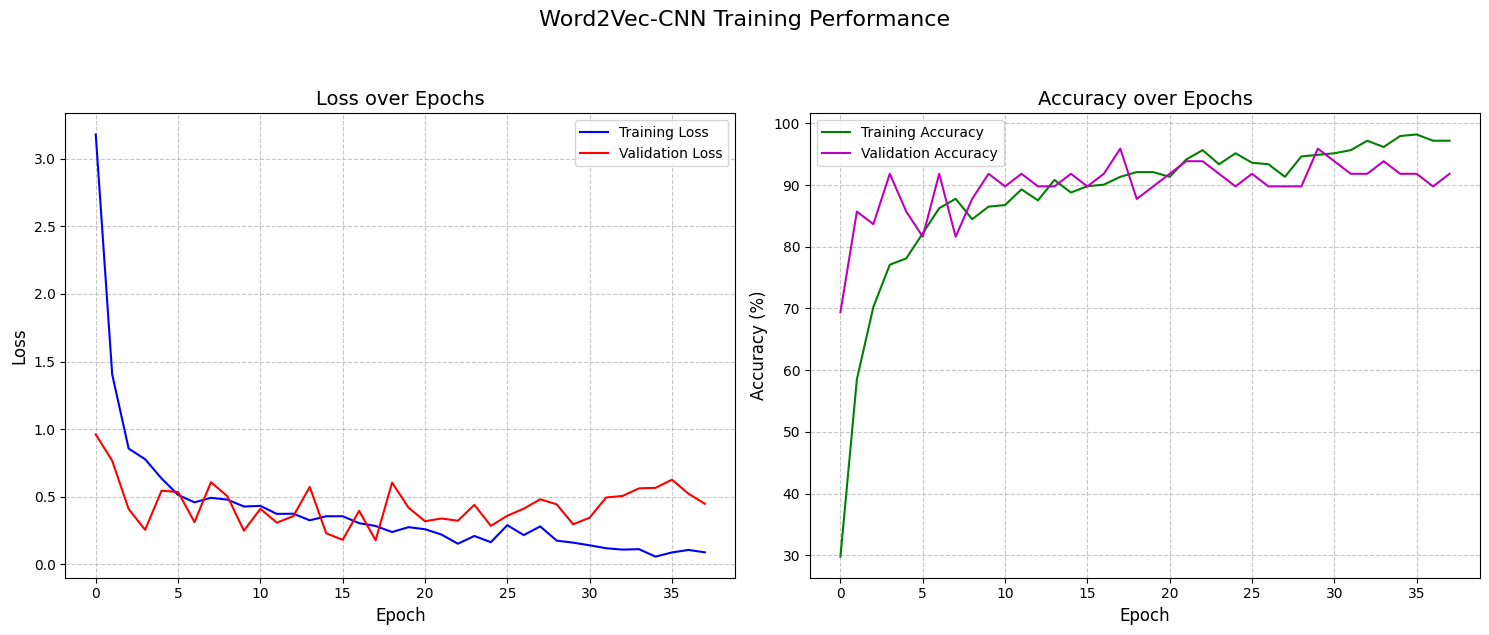

In [28]:
plt.figure(figsize=(15, 6))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.plot(val_losses, 'r-', label='Validation Loss')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss over Epochs', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'g-', label='Training Accuracy')
plt.plot(val_accuracies, 'm-', label='Validation Accuracy')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Accuracy over Epochs', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

plt.suptitle('Word2Vec-CNN Training Performance', fontsize=16, y=1.05)
plt.tight_layout()

In [18]:
# Evaluation on test set
test_loss, test_accuracy, y_pred_word2vec_cnn, y_true_word2vec_cnn = evaluate(w2v_cnn, w2v_test_loader, w2v_cnn_criterion, device)

print('Word2Vec-CNN Classifer:')
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.2f}%")
print(classification_report(y_true_word2vec_cnn, y_pred_word2vec_cnn, target_names=malware_families))

Word2Vec-CNN Classifer:
Test loss: 0.5454
Test accuracy: 86.00%
              precision    recall  f1-score   support

      adload       1.00      1.00      1.00         7
      bancos       0.75      0.43      0.55         7
 onlinegames       0.67      0.86      0.75         7
    vbinject       0.86      0.86      0.86         7
       vundo       0.78      0.88      0.82         8
   winwebsec       1.00      1.00      1.00         7
      zwangi       1.00      1.00      1.00         7

    accuracy                           0.86        50
   macro avg       0.86      0.86      0.85        50
weighted avg       0.86      0.86      0.85        50



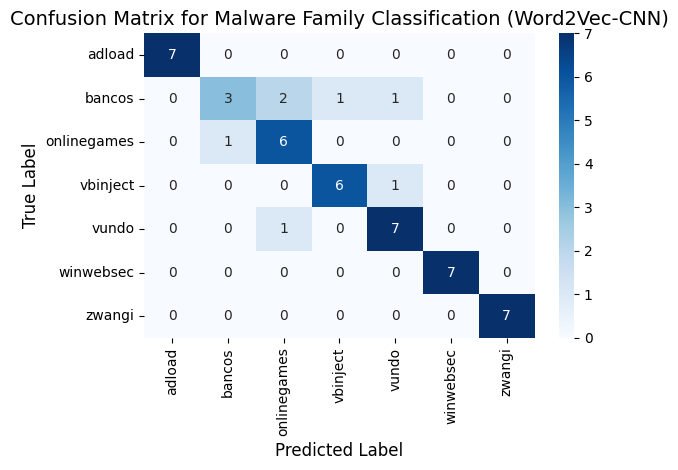

In [19]:
# Generate confusion matrix
cm_word2vec_cnn = confusion_matrix(y_true_word2vec_cnn, y_pred_word2vec_cnn)
cm_word2vec_cnn_df = pd.DataFrame(cm_word2vec_cnn, index=malware_families, columns=malware_families)

# Create a heatmap from the confusion matrix
sns.heatmap(cm_word2vec_cnn_df, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix for Malware Family Classification (Word2Vec-CNN)', fontsize=14)
plt.tight_layout()

## Section 4: Save Results

In [ ]:
# Update accuracies DataFrame
accuracies_df = pd.read_pickle('accuracies.pkl')

new_accuracy = pd.DataFrame({
    'embedding': ['Word2Vec'],
    'classifier': ['CNN'],
    'accuracy': [round(accuracy_score(y_true_word2vec_cnn, y_pred_word2vec_cnn), 2)]
})

accuracies_df = pd.concat([accuracies_df, new_accuracy], ignore_index=True)
accuracies_df.to_pickle('accuracies.pkl')